In [19]:
import pandas as pd
import re
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [34]:
# viewership data
view_train_X = pd.read_csv('view_train_X.csv')
view_test_X = pd.read_csv('view_test_X.csv')

view_train_y = pd.read_csv('view_train_y.csv')
view_test_y = pd.read_csv('view_test_y.csv')

# subscription data
sub_train_X = pd.read_csv('NYU_Capstone_Project/data_preprocessing/train_x_rfm.csv')
sub_train_y = pd.read_csv('NYU_Capstone_Project/data_preprocessing/train_y_rfm.csv')

sub_test_X = pd.read_csv('NYU_Capstone_Project/data_preprocessing/test_x_rfm.csv')
sub_test_y = pd.read_csv('NYU_Capstone_Project/data_preprocessing/test_y_rfm.csv')

In [55]:
def preprocess_X(view_df, sub_df):
    view_df = view_df.rename(columns={'NETWORK': 'BRAND'})
    sub_df = sub_df.drop(columns=['Unnamed: 0', 'SUB', 'DATE', 'FREQUENCY', 'RECENCY'])

    df_X = pd.merge(view_df, sub_df, on=['ID', 'BRAND'], how='outer')

    # impute NAs
    df_X['DAYS_AFTER_LAST_WATCH'].fillna(365, inplace=True)
    df_X['DAYS_AFTER_FIRST_WATCH'].fillna(365, inplace=True)
    df_X['NUM_SESSIONS'].fillna(0, inplace=True)
    df_X['UNIQUE_GENRES_WATCHED'].fillna(0, inplace=True)
    df_X['UNIQUE_PROGRAMS_WATCHED'].fillna(0, inplace=True)
    df_X['MEAN_DURATION_MINUTES'].fillna(0, inplace=True)
    df_X['SUM_DURATION_MINUTES'].fillna(0, inplace=True)
    df_X['SUM_AD_REVENUE'].fillna(0, inplace=True)
    df_X['REVENUE'].fillna(0, inplace=True)

    return df_X

def preprocess_y(view_df, sub_df):
    view_df = view_df.rename(columns={'NETWORK': 'BRAND'})
    sub_df = sub_df.drop(columns=['Unnamed: 0', 'SUB', 'DATE', 'FREQUENCY', 'RECENCY'])

    df_y = pd.merge(view_df, sub_df, on=['ID', 'BRAND'], how='outer')

    selected_columns = ['ID', 'BRAND', 'SUM_AD_REVENUE', 'REVENUE']
    df_y = df_y[selected_columns]

    df_y['SUM_AD_REVENUE'].fillna(0, inplace=True)
    df_y['REVENUE'].fillna(0, inplace=True)
    df_y['TOTAL_REVENUE'] = df_y['SUM_AD_REVENUE'] + df_y['REVENUE']

    df_y = df_y[['ID', 'BRAND', 'TOTAL_REVENUE']]

    return df_y

In [56]:
train_X = preprocess_X(view_train_X, sub_train_X)
test_X = preprocess_X(view_test_X, sub_test_X)

train_y = preprocess_y(view_train_y, sub_train_y)
test_y = preprocess_y(view_test_y, sub_test_y)

In [61]:
df_train = pd.merge(train_X, train_y, on=['ID', 'BRAND'], how='inner')
df_test = pd.merge(test_X, test_y, on=['ID', 'BRAND'], how='inner')

In [63]:
y_columns = ['ID', 'BRAND', 'TOTAL_REVENUE']

train_y_final = df_train['TOTAL_REVENUE']
train_X_final = df_train.drop(columns = y_columns)

test_y_final = df_test['TOTAL_REVENUE']
test_X_final = df_test.drop(columns = y_columns)

In [64]:
# Create an XGBoost DMatrix for training
dtrain = xgb.DMatrix(train_X_final, label=train_y_final)
dtest = xgb.DMatrix(test_X_final, label=test_y_final)

# Define parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'max_depth': 4,                   # Maximum depth of a tree
    'eta': 0.1,                       # Learning rate
    'verbosity': 1                    # Verbosity of printing messages
}

# Train the XGBoost model
num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Predict on the test set
preds = bst.predict(dtest)

# Evaluate the performance using Mean Squared Error
mse = mean_squared_error(test_y_final, preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1138.3272910798057


In [14]:
test_y_final


0        60.00
1         0.63
2        59.90
3         0.40
4         0.33
         ...  
28826     0.84
28827     0.08
28828    24.98
28829     0.71
28830     0.62
Name: TOTAL_REVENUE, Length: 28831, dtype: float64

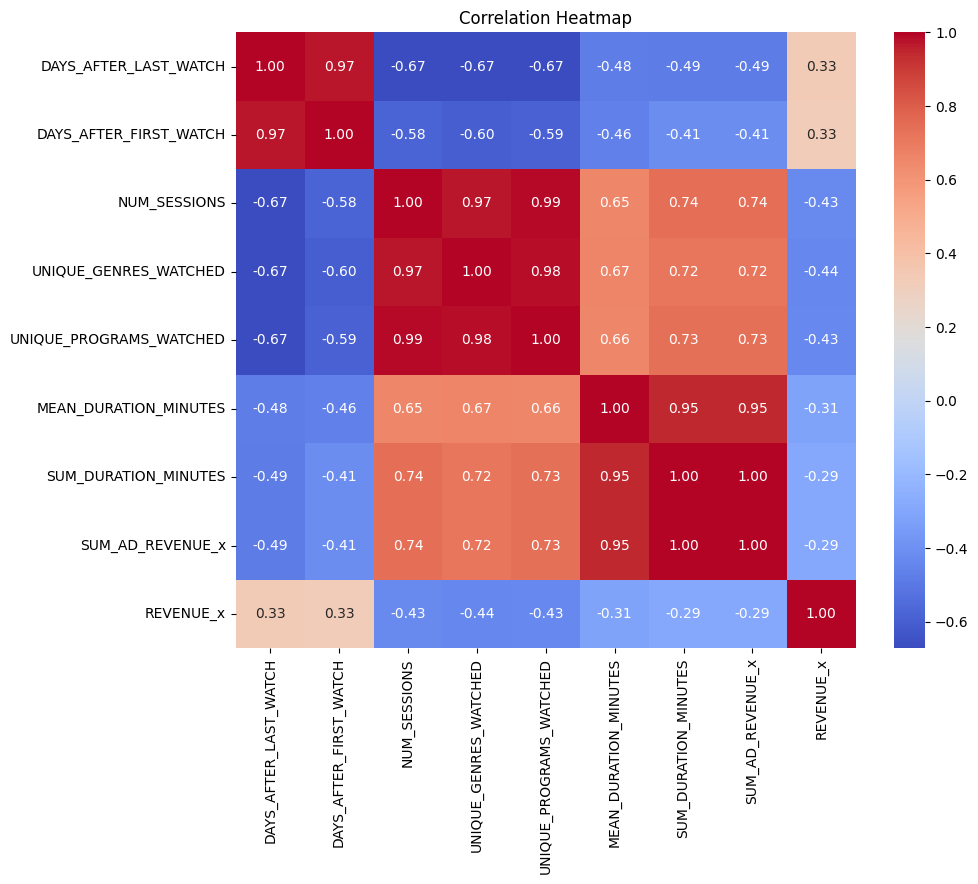

In [24]:
# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 8))
correlation_matrix = train_X_final.corr()  # Calculates the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
